# <img src="assets/logo_infnetv1.png" alt="Infnet logo" height="45"/> Projeto de Disciplina Algoritmos de Clusterização
<img src="https://img.shields.io/badge/python-v._3.11.5-blue?style=flat-square&logo=python&logoColor=white" alt="python_logo" height="20"/>
<img src="https://img.shields.io/badge/jupyter-v._5.7.2-blue?style=flat-square&logo=jupyter&logoColor=white" alt="jupyter_logo" height="20"/>
<img src="https://img.shields.io/badge/anaconda-v._23.7.4-blue?style=flat-square&logo=anaconda&logoColor=white" alt="anaconda_logo" height="20"/>

#### Aluno: 

- Lauro Barbosa <a href="https://github.com/LMRocha/pd_algoritmos_clusterizacao"><img src="https://img.shields.io/badge/Github-151b23?style=flat-square&logo=github" alt="github_logo" height="20"/></a>

### Sobre o projeto:

---

Se trata de um modelo de aprendizagem não supervisionado de clusterização relativos a dados de paises ao redor do mundo. Os dados foram extraídos do site do <a href="https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data">`Kaggle`</a>.

#### Convenções de reprodutibilidade:

- Todas as bibliotecas se encontram no arquivo `📄requirements.txt`
- Para mais informções, consulte nosso `README.md`

## Ambiente de execução

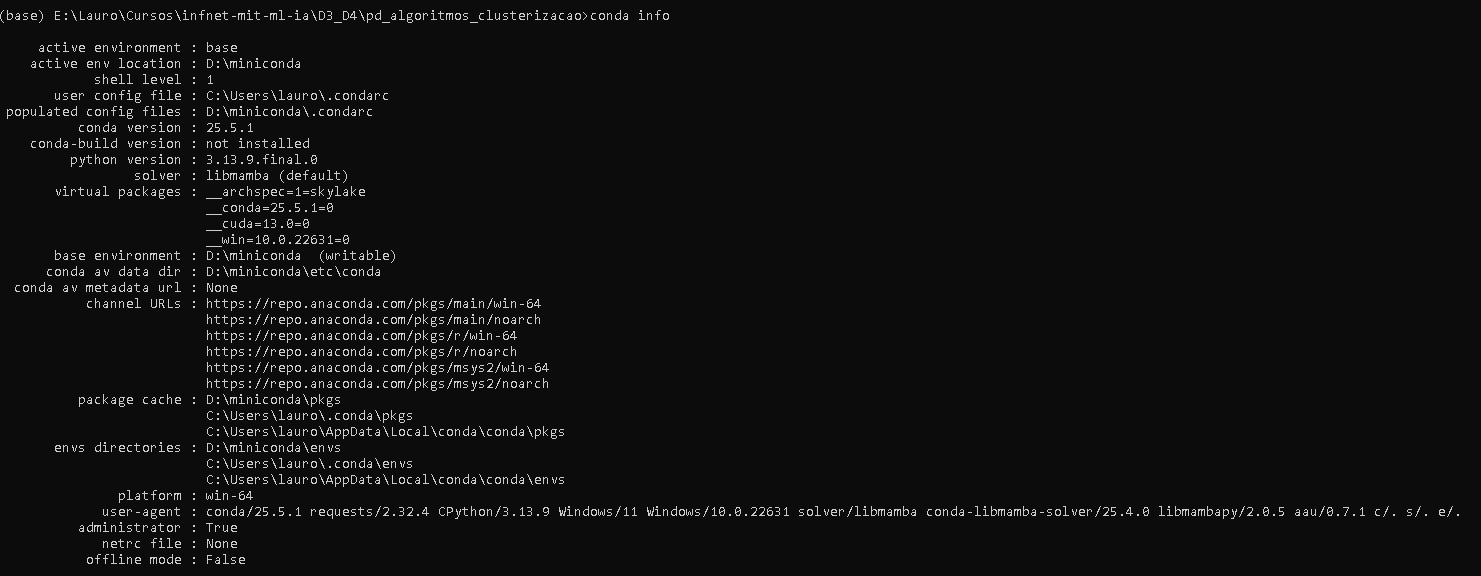

## Importação as bibliotecas

In [277]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.metrics.pairwise import euclidean_distances

SEED=42
np.random.seed(SEED)

## Geração dos diretórios e download do dataset

In [278]:
# Inicializar a API do Kaggle
api = KaggleApi()
api.authenticate()

# Criar o diretório se não existir
data_path = 'data'
os.makedirs(data_path, exist_ok=True)

# Baixar os dados do Kaggle
api.dataset_download_files('rohan0301/unsupervised-learning-on-country-data', path=data_path, unzip=True)

path_raw = 'data/'
file_raw_1 = 'Country-data.csv'
file_raw_2 = 'data-dictionary.csv'
pathfile_raw_1 = os.path.join(path_raw, file_raw_1)
pathfile_raw_2 = os.path.join(path_raw, file_raw_2)

Dataset URL: https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data


## Definição de funções

In [279]:
def histogram_per_variable_plot(X):
    for col in X.columns:
        plt.figure()
        plt.hist(X[col].dropna())
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("freq")
        plt.show()

def pair_plot(data,figsize_x,figsize_y):
    sns.pairplot(data=data,diag_kind='kde')
    plt.figure(figsize=(figsize_x, figsize_y))
    plt.show()

def scatter_plot(data,x,y,figsize_x,figsize_y):
    sns.scatterplot(data=data,x=x,y=y)
    plt.figure(figsize=(figsize_x, figsize_y))
    plt.show()

def plot_data_clusters(data,centroids):
    for c in sorted(np.unique(data['cluster'])):
        subset = data[data["cluster"] == c]
        plt.scatter(subset["PCA1"], subset["PCA2"], s=80, alpha=0.8, label=f"Cluster {c}")

    plt.scatter(centroids[:,0], centroids[:,1], marker="X", s=100)
    plt.title("Clusters de Países")
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_dendogram(X):
    # Plot the dendrogram
    plt.figure(figsize=(20, 6))
    
    # Compute the linkage matrix
    Z = linkage(X, method='ward')
    dendrogram(Z,labels=X.index.tolist())
    plt.title("Dendrogram for Agglomerative Clustering")
    plt.xlabel("Sample index")
    plt.ylabel("Distance")
    plt.show()

## Análise exploratória

### Detalhamento do Dataset

In [280]:
df = pd.read_csv(pathfile_raw_1)
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


<span style="color: green;">Conforme mostrado acima, o dataset compõe 167 países</span>

In [281]:
df['country'].shape

(167,)

<span style="color: green;">Gráficos a faixa dinâmica</span>

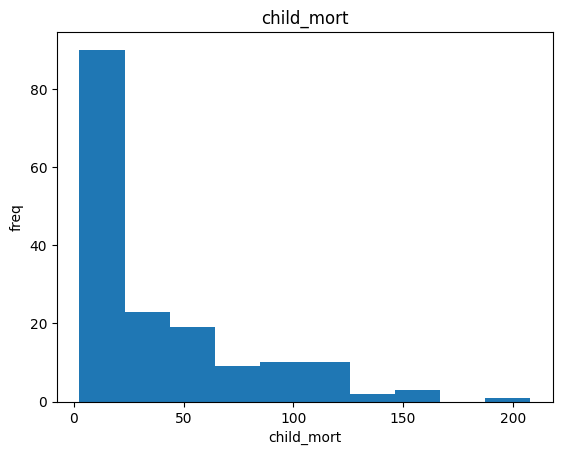

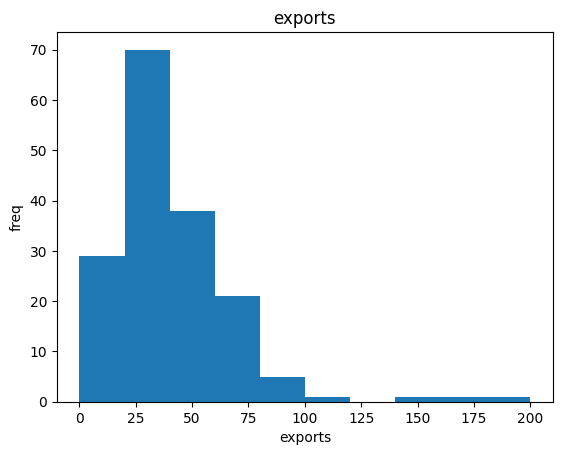

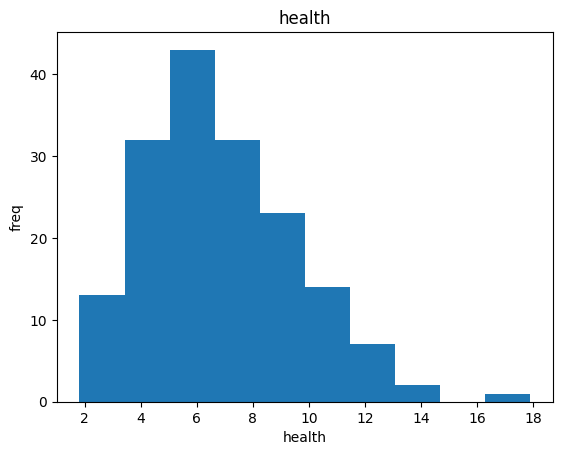

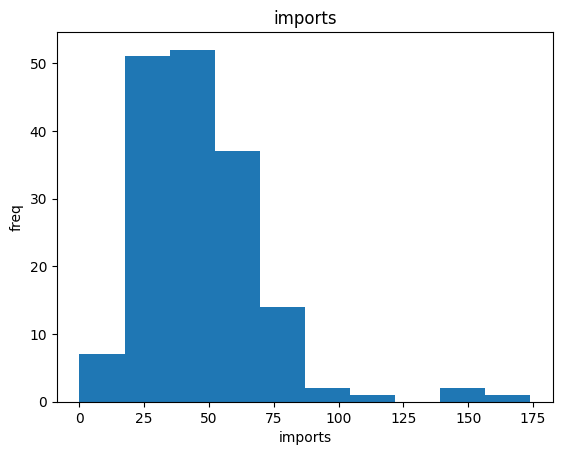

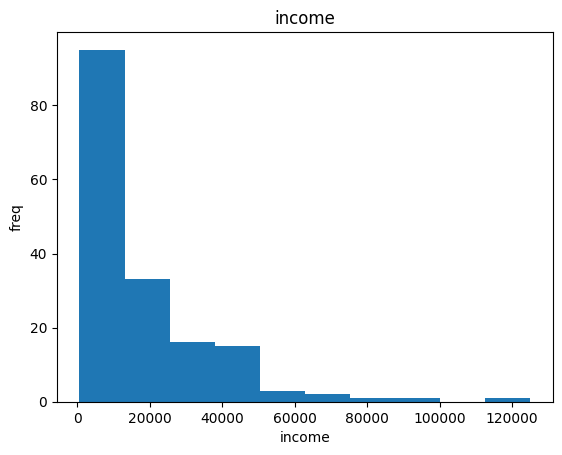

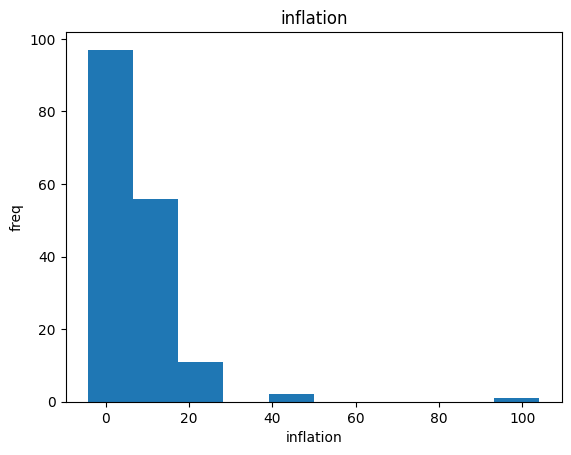

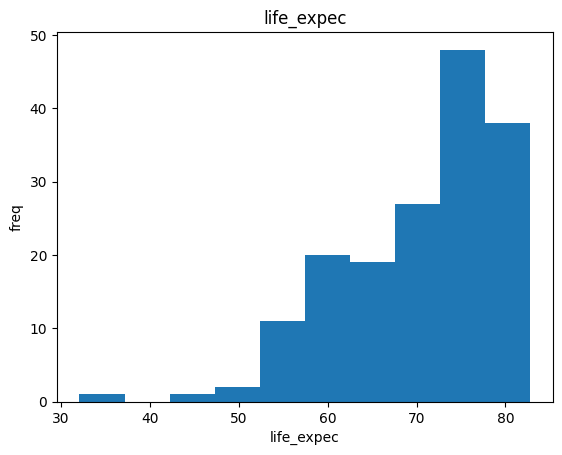

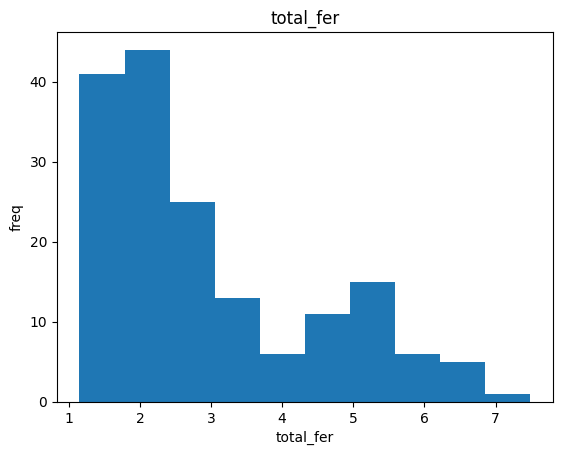

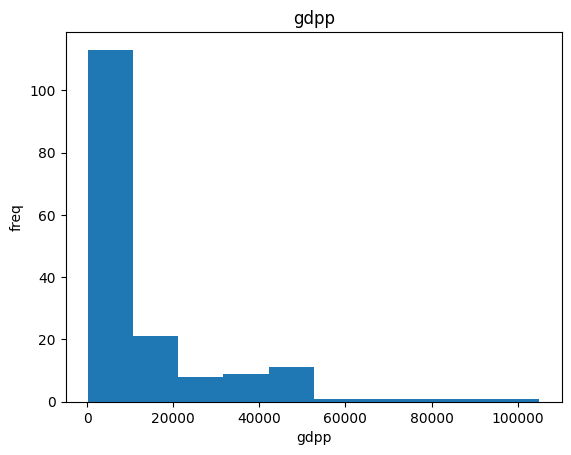

In [282]:
histogram_per_variable_plot(df.drop(['country'],axis=1))

### Tratamento dos dados

<b> Verificação de dados nulos no dataset

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


<b> Verificacao de dados duplicados no dataset

In [284]:
df[df['country'].duplicated() == True]['country']

Series([], Name: country, dtype: object)

<b> Padronização  dos dados

In [285]:
df.drop(['country'],axis=1).columns

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [286]:
scaler = StandardScaler()
df_scaled_features = pd.DataFrame(columns=df.drop(['country'],axis=1).columns,data=scaler.fit_transform(df.drop(['country'],axis=1)))

In [287]:
df_scaled = pd.concat([df['country'],df_scaled_features],axis=1)

In [288]:
df_scaled

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,Albania,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,Algeria,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,Angola,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,Antigua and Barbuda,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,-0.225578,0.200917,-0.571711,0.240700,-0.738527,-0.489784,-0.852161,0.365754,-0.546913
163,Venezuela,-0.526514,-0.461363,-0.695862,-1.213499,-0.033542,3.616865,0.546361,-0.316678,0.029323
164,Vietnam,-0.372315,1.130305,0.008877,1.380030,-0.658404,0.409732,0.286958,-0.661206,-0.637754
165,Yemen,0.448417,-0.406478,-0.597272,-0.517472,-0.658924,1.500916,-0.344633,1.140944,-0.637754


In [289]:
Xs = df_scaled.drop(['country'],axis=1)

<b> Redução de dimensionalidade com PCA para facilitar o plot em 2D

In [290]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xs)

In [291]:
df_xpca = pd.DataFrame(columns=['PCA1','PCA2'],data=X_pca)

<b> Demonstração dos clusters "esféricos" em PCA2

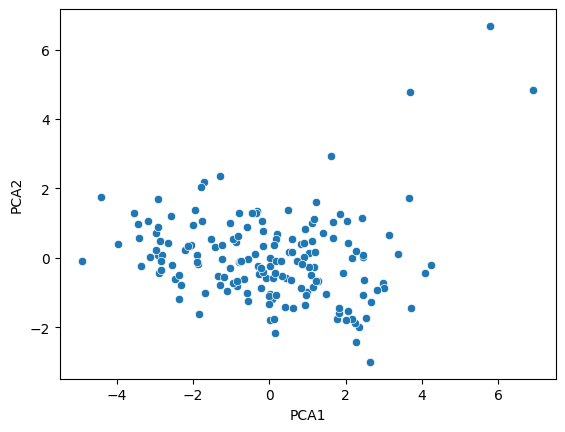

<Figure size 1000x500 with 0 Axes>

In [292]:
scatter_plot(data=df_xpca,x='PCA1',y='PCA2',figsize_x=10,figsize_y=5)

### Treinamento KMeans

<b style="color: green;"> Etapas até a convergência </b>
<br>
<p style="color: green;">1 - Escolher a quantidade de grupos K</p>
<p style="color: green;">2 - Inicialização dos K centróides (aleatórios ou por algum critério, ex: k-means++)</p>
<p style="color: green;">3 - Atribuição: para cada ponto, medir distância para cada centróide → rotular pelo centróide mais próximo</p>
<p style="color: green;">4 - Recalcular centróides: para cada grupo, média dos pontos daquele grupo</p>
<p style="color: green;">5 - Teste de convergência: rótulos não mudaram ou mudança de centróide &lt; tolerância → senão: nova reatribuição</p>
<br>
<b style="color: green;"> Sensibilidade a outliers </b>
<p style="color: green;"> Como o objetivo é minimizar a distância as somas das distâncias ao centroid, qualquer valor extremo puxa a média (centroid é a média) </p>

<b style="color: green;"> Alternativa  - DBScan </b>
<p style="color: green;"> Não utiliza centróide , não tenta minimizar a distância global e todo valor extremo é considerado um ruído </p>

<b> realizando o treinamento do modelo kmeans e gerando as labels

In [293]:
model_kmeans = KMeans(n_clusters=3,max_iter=500,init='k-means++', n_init=10)
km_labels = model_kmeans.fit_predict(X_pca)
km_centroids = model_kmeans.cluster_centers_

<b> criação da coluna 'cluster'

In [294]:
df_xpca['cluster'] = km_labels
df_xpca

,PCA1,PCA2,cluster
0,-2.913025,0.095621,1
1,0.429911,-0.588156,2
2,-0.285225,-0.455174,2
3,-2.932423,1.695555,1
4,1.033576,0.136659,2
...,...,...,...
162,-0.820631,0.639570,1
163,-0.551036,-1.233886,1
164,0.498524,1.390744,2
165,-1.887451,-0.109453,1


<b style="color: green;">Análise dos clusters gerados pelo KMeans</b>
<br>
<span style="color: green;">É possivel ver que há uma grande diferença no distancimaento dos centroids que representam paises desenvolvidos (Cluster 0), dos paises que represetnam o quantitatido dos países subdesenvolvidos (Cluster 1 e 2)</span>
<br>
<br>
<span style="color: green;">Os países desenvolvidos se destacam por maiores valores em features como life_expec, gdpp, income enquanto paises subdesenvolvidos se destacam por maiores valores em child_mort por exemplo</span>
<br>
<br>
<span style="color: green;">O pais que melhor representa seu agrupamento é o pais mais próximo do centroid, analisando abaixo podemos extrair os seguintes paises:
</span>
<br>
<b style="color: green;">Singapore -> cluster 0 <b><br>
<b style="color: green;">Senegal   -> cluster 1 <b><br>
<b style="color: green;">Lebanon   -> cluister 2<b><br>

In [295]:
labels = model_kmeans.labels_
centroids = model_kmeans.cluster_centers_

out = []
for k in range(len(centroids)):
    idx = np.where(labels == k)[0]                  # points in this cluster
    pts = df_xpca.drop(['cluster'],axis=1) .iloc[idx]
    d = np.linalg.norm(pts - centroids[k], axis=1)  # euclidean
    nearest = idx[np.argmin(d)]
    out.append(nearest)

nearest_points = df_xpca.iloc[out]
nearest_points.index = nearest_points.index.map(df['country'])
nearest_points

,PCA1,PCA2,cluster
Singapore,5.783376,6.682090,0
Senegal,-1.912170,0.091560,1
Lebanon,1.171991,-0.256295,2


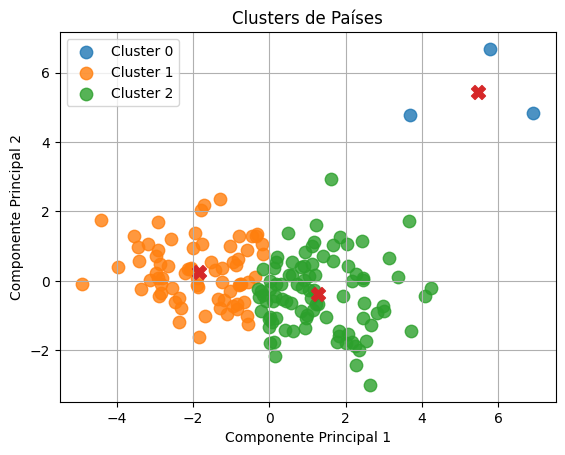

In [296]:
plot_data_clusters(data=df_xpca,centroids=km_centroids)

### Treinamento Agglomerative Cluster

In [297]:
agg_cluster = AgglomerativeClustering(n_clusters=3)
agg_labels = agg_cluster.fit_predict(X_pca)

In [298]:
df_xpca['cluster'] = agg_labels
df_xpca.index = df_xpca.index.map(df['country'])
df_xpca

,PCA1,PCA2,cluster
Afghanistan,-2.913025,0.095621,1
Albania,0.429911,-0.588156,0
Algeria,-0.285225,-0.455174,0
Angola,-2.932423,1.695555,1
Antigua and Barbuda,1.033576,0.136659,0
...,...,...,...
Vanuatu,-0.820631,0.639570,1
Venezuela,-0.551036,-1.233886,0
Vietnam,0.498524,1.390744,0
Yemen,-1.887451,-0.109453,1


<b> Geração do dendograma

<b style="color: green;">Análise dos dendograma</b>
<br>
<span style="color: green;">É possivel notar o grande salto que temos da distância 30, do cluster 1, o que deixa a comparação semelhante a distância do centroid representante dos paises desenvolvidos para os demais países</span>

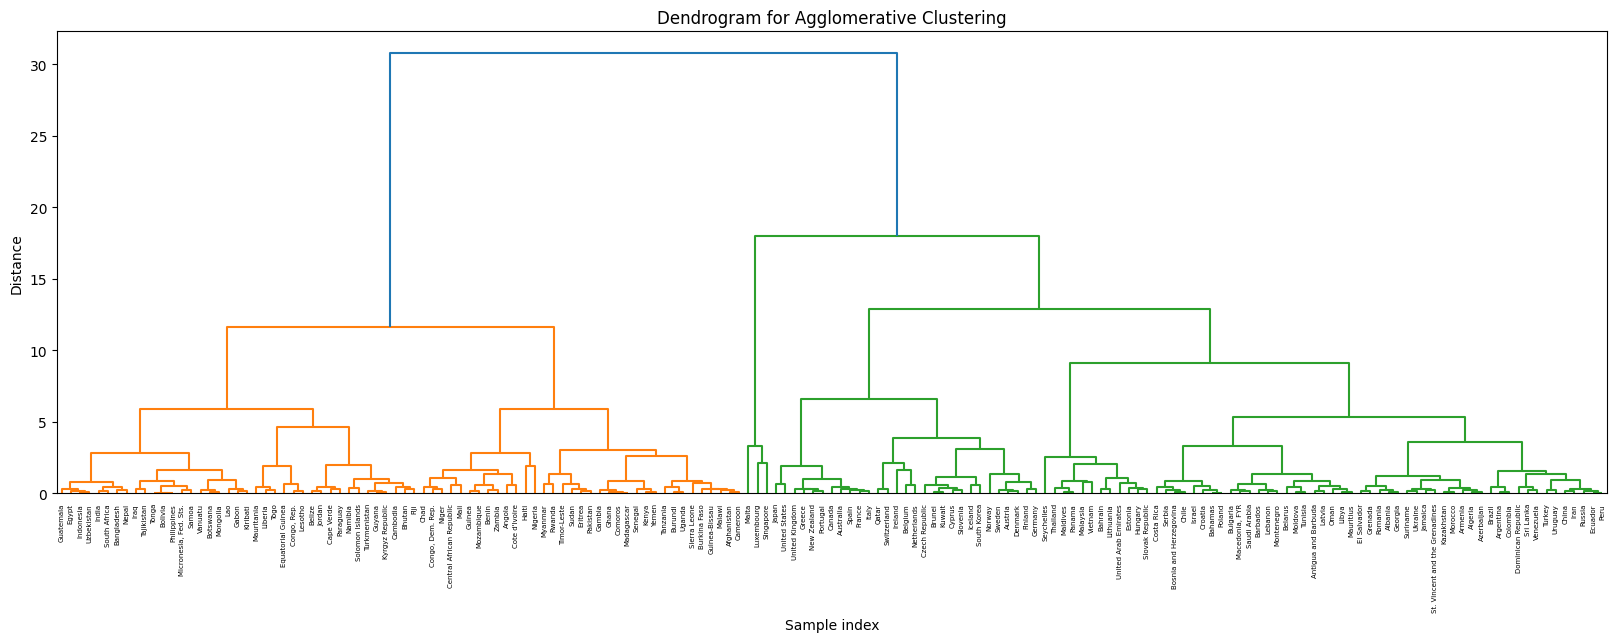

In [299]:
plot_dendogram(df_xpca)